In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Extraer datos

In [ ]:
df_customers = pd.read_csv('../data/Mall_Customers.csv')
df_customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Limpiar datos

In [ ]:
df_customers = df_customers.drop(['CustomerID'], axis=1)
df_customers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [ ]:
df_customers.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## Transformar datos

### Variables numéricas

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
numerical_data = df_customers[numerical_columns]
scaler = StandardScaler().fit(numerical_data.values)
numerical_data = scaler.transform(numerical_data.values)
scaled_num_data = pd.DataFrame(numerical_data, columns=numerical_columns)
scaled_num_data.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


### Variables categóricas

In [ ]:
gender = df_customers['Gender']
df = scaled_num_data.join(gender)
df = pd.get_dummies(df)
df = df.drop(['Gender_Male'], axis=1)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female
0,-1.424569,-1.738999,-0.434801,0
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,1
3,-1.137502,-1.700830,1.040418,1
4,-0.563369,-1.662660,-0.395980,1


## Explorar data

In [ ]:
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


### Matriz de covarianza

In [ ]:
covariance_matrix = np.cov(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].T)
covariance_matrix

array([[ 1.00502513, -0.01246034, -0.3288712 ],
       [-0.01246034,  1.00502513,  0.00995261],
       [-0.3288712 ,  0.00995261,  1.00502513]])

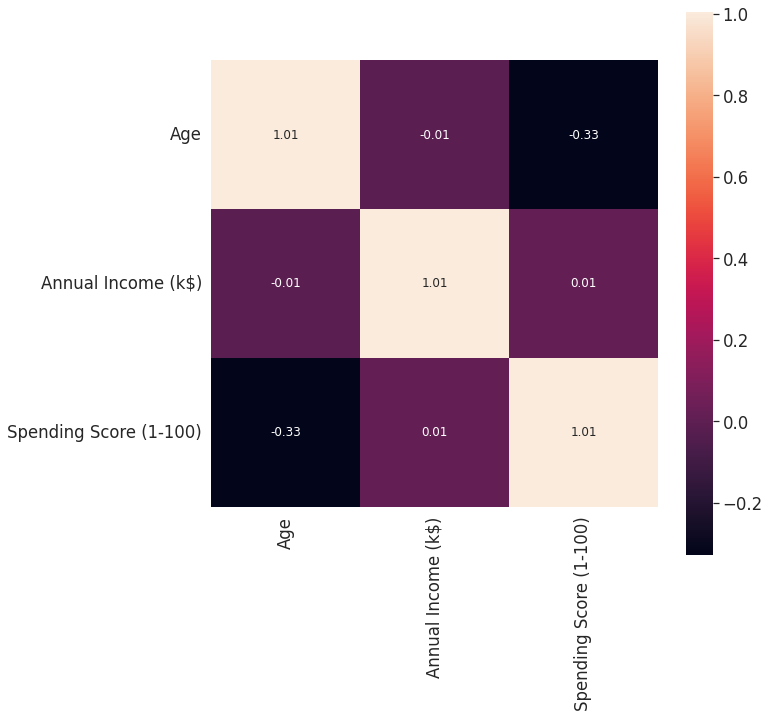

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(covariance_matrix,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 12},
                yticklabels=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
                xticklabels=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])

La matriz de covarianza muestra que las variables no están tan correlacionadas. La única relación que se observa es entre la edad y el score de gasto con una correlación de -0.33. Lo cual indica que hay perfiles que a mayor edad gastan menos.

### PCA

Veamos si le podemos reducir la dimensionalidad del dataset utilizando PCA

[0.4095285  0.3081674  0.20723465 0.07506945]


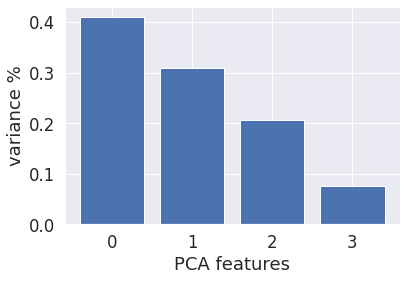

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principal_components = pca.fit_transform(df)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)

PCA_components = pd.DataFrame(principal_components)

Como vemos los primeros 3 componentes de PCA explican el 90% de la varianza del dataset

## Implementar modelo

Utilizaremos K-means para segmentar los datos

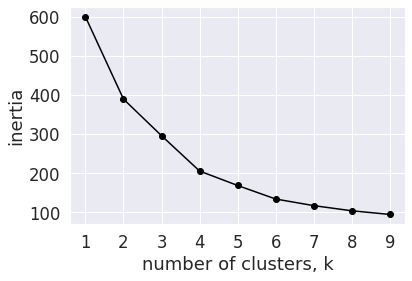

In [ ]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Utilizando el método del codo en la figura anterior, el número óptimo de clusters parece ser de 4

Ahora que tenemos el número ideal de clusters, hagamos las predicciones para la data.

In [ ]:
df = pd.read_csv('../data/Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:3])

k_predict = model.predict(PCA_components.iloc[:,:3])
frame = pd.DataFrame(df)
frame['cluster'] = k_predict
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,3
1,Male,21,15,81,3
2,Female,20,16,6,3
3,Female,23,16,77,3
4,Female,31,17,40,3


Para ver la tendencia de comportamiento de estos 3 grupos, encontremos el promedio de las variables de cada cluster

In [ ]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,39.368421,86.500000,19.578947
1,1,53.984615,47.707692,39.969231
2,2,32.875000,86.100000,81.525000
3,3,25.438596,40.000000,60.298246


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

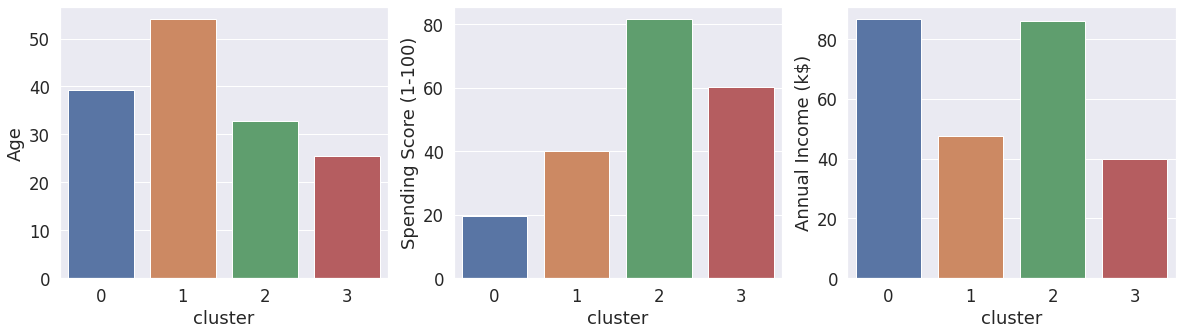

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.barplot(x='cluster',y='Age',data=avg_df, ax=ax[0])
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df, ax=ax[1])
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df, ax=ax[2])

In [ ]:
Analizemos la distribución de género en los clusters y el dataset

In [ ]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2

Gender
cluster Gender        
0       Female      19
        Male        19
1       Female      37
        Male        28
2       Female      22
        Male        18
3       Female      34
        Male        23

In [ ]:
df3 = pd.DataFrame(df.groupby(['Gender'])['Gender'].count())
df3

,Gender
Gender,
Female,112
Male,88


En general, el dataset tiene más datos de mujeres y lo mismo se refleja en cada uno de los clusters por lo que el género no será de relevancia para caracterizar los clusters

## Interpretar resultados

## Recomendaciones según los perfiles de los clientes

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=246fa214-d73c-42c3-9780-c1f3dc076381' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>